This vignette is part of the workshop: [Hands-on Tour of the Visium Spatial Gene Expression Analysis Journey](https://www.10xgenomics.com/analysis-guides/workshop-visium-hd-analysis).
此小插图是研讨会的一部分：Visium 空间基因表达分析之旅动手之旅。

We will begin by installing the necessary packages.
我们将从安装必要的软件包开始。

In [ ]:
install.packages("remotes")
install.packages("devtools")
system("apt install libgsl-dev", intern=TRUE)
devtools::install_github("paulponcet/lplyr")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = '3.19',ask = FALSE)

BiocManager::install("clusterProfiler")
BiocManager::install("enrichplot")
BiocManager::install("ggplot2")
BiocManager::install("msigdbr")
BiocManager::install("dplyr")
BiocManager::install("DOSE")
BiocManager::install("forcats")
BiocManager::install("AnnotationDbi")
BiocManager::install("org.Hs.eg.db")

Next, load these required packages into the environment.
接下来，将这些必需的软件包加载到环境中。

In [2]:
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(msigdbr)
library(dplyr)
library(lplyr)
library(DOSE)
library(forcats)
library(AnnotationDbi)
library(org.Hs.eg.db)



clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lplyr’


The following object is masked from ‘package:dplyr’:

    pull


DOSE v3.30.5  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘Bioc

Read the in CSV file containing gene expression information and take a look at the dataframe
读取包含基因表达信息的 CSV 文件并查看数据帧

In [10]:
#download.file("https://raw.githubusercontent.com/10XGenomics/analysis_guides/main/Visium_HD_GSEA/ROI_Features.csv", "ROI_Features.csv")
setwd("/home/lcr/Desktop/BioWork/lcr_Bio/data_ingestion/analysis_guides-main/Visium_HD_GSEA")
getwd()
df <- read.csv("ROI_Features.csv", header = TRUE)
head(df)

[1] "/home/lcr/Desktop/BioWork/lcr_Bio/data_ingestion/analysis_guides-main/Visium_HD_GSEA"

,SYMBOL,Log2FC
,<chr>,<dbl>
1,COL1A2,5.897953
2,COL1A1,5.886694
3,SFRP4,6.789303
4,COL3A1,5.683523
5,COL11A1,7.466828
6,MMP2,5.869154


How many genes are in our list?
我们的列表中有多少个基因？

In [11]:
nrow(df)

[1] 18072

GSEA requires Entrez IDs as input. These are unique integer identifiers for genes from NCBI. We will use AnnotationDbi to find the IDs for each gene symbol in our list and take a look at the top of the data frame to see what it looks like.
GSEA 需要 Entrez ID 作为输入。这些是 NCBI 中基因的唯一整数标识符。我们将使用 AnnotationDbi 查找列表中每个基因符号的 ID，并查看数据框的顶部以查看它是什么样子的。

In [12]:
entrez_data <- AnnotationDbi::select(org.Hs.eg.db, keys = df$SYMBOL,columns = c("SYMBOL", "ENTREZID"),keytype = "SYMBOL")
head(entrez_data)

'select()' returned many:many mapping between keys and columns



,SYMBOL,ENTREZID
,<chr>,<chr>
1,COL1A2,1278
2,COL1A1,1277
3,SFRP4,6424
4,COL3A1,1281
5,COL11A1,1301
6,MMP2,4313


Not every gene symbol has an associated Entrez ID. We will need to remove genes that do not have an Entrez ID ("NA") from our input list.
并非每个基因符号都有关联的 Entrez ID。我们需要从输入列表中删除没有 Entrez ID （“NA”） 的基因。

In [13]:
anno_result <- entrez_data %>%
  filter(!is.na(ENTREZID)) %>%
  inner_join(df, by = "SYMBOL",relationship = "many-to-many")

head(anno_result)

,SYMBOL,ENTREZID,Log2FC
,<chr>,<chr>,<dbl>
1,COL1A2,1278,5.897953
2,COL1A1,1277,5.886694
3,SFRP4,6424,6.789303
4,COL3A1,1281,5.683523
5,COL11A1,1301,7.466828
6,MMP2,4313,5.869154


How many genes remain after filtering NAs?
过滤 NAs 后还剩下多少个基因？

In [14]:
nrow(anno_result)

[1] 17635

The starting gene number was 18,072. So, we removed 437 or ~2% of our gene list due to NAs. This is not a large proportion of our gene list and so we will proceed assuming the list is still representative of our sample.
起始基因数为 18,072。因此，由于 NAs，我们删除了 437 个或 ~2% 的基因列表。这在我们的基因列表中占很大比例，因此我们将继续假设该列表仍然代表我们的样本。

Next, we will turn this data frame into a named vector that has the Entrez ID and associated Log2FC information and sort it largest Log2FC to smallest.
接下来，我们将此数据帧转换为具有 Entrez ID 和关联 Log2FC 信息的命名向量，并将其从最大 Log2FC 到最小排序。

In [15]:
geneList <- with(anno_result, setNames(Log2FC, ENTREZID))
geneList <- sort(geneList, decreasing = TRUE)

Next, we need to prepare our reference gene sets that we will use for analysis. There are a number of databases available to use. We chose to use a popular one, Gene Ontology: Molecular Function. We can access the gene sets in this database with the msigdbr package from MSigDB. To learn more about the gene sets available through this resource, go to this web page: https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp
接下来，我们需要准备用于分析的参考基因集。有许多数据库可供使用。我们选择使用一个流行的 Gene Ontology： Molecular Function。我们可以使用 MSigDB 中的 msigdbr 包访问此数据库中的基因集。要了解有关此资源提供的基因集的更多信息，请访问此网页：https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp
We find there is a database of computational gene sets defined by expression neighborhoods centered around cancer-associated genes. This database is relevant to our data, so we will use this one.
我们发现有一个计算基因集数据库，由以癌症相关基因为中心的表达邻域定义。这个数据库与我们的数据相关，因此我们将使用这个数据库。

In [16]:
c4_t2g <- msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CGN") %>%
  dplyr::select(gs_name, entrez_gene)
head(c4_t2g)

gs_name,entrez_gene
<chr>,<int>
CAR_HPX,13
CAR_HPX,130
CAR_HPX,173
CAR_HPX,183
CAR_HPX,6718
CAR_HPX,229


Now that we have our ranked gene list and gene set reference inputs, we can run GSEA.
现在我们有了排名基因列表和基因集参考输入，我们可以运行 GSEA。

In [17]:
c4 <- GSEA(geneList, TERM2GENE = c4_t2g)
c4

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (38.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 87 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minS

#
# Gene Set Enrichment Analysis
#
#...@organism 	 UNKNOWN 
#...@setType 	 UNKNOWN 
#...@geneList 	 Named num [1:17635] 7.75 7.47 6.97 6.92 6.83 ...
 - attr(*, "names")= chr [1:17635] "1311" "1301" "5270" "1118" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...165 enriched terms found
'data.frame':	165 obs. of  11 variables:
 $ ID             : chr  "GNF2_CCNA2" "GNF2_PCNA" "GNF2_RFC4" "GNF2_PA2G4" ...
 $ Description    : chr  "GNF2_CCNA2" "GNF2_PCNA" "GNF2_RFC4" "GNF2_PA2G4" ...
 $ setSize        : int  65 64 57 66 59 59 52 35 47 57 ...
 $ enrichmentScore: num  -0.674 -0.681 -0.692 -0.651 -0.668 ...
 $ NES            : num  -3.35 -3.35 -3.27 -3.21 -3.19 ...
 $ pvalue         : num  1e-10 1e-10 1e-10 1e-10 1e-10 ...
 $ p.adjust       : num  1.47e-09 1.47e-09 1.47e-09 1.47e-09 1.47e-09 ...
 $ qvalue         : num  7.09e-10 7.09e-10 7.09e-10 7.09e-10 7.09e-10 ...
 $ rank           : num  5106 4184 4410 4410 5163 ...
 $ leading_edge   : chr  "tags=85%, list=29%, signal

The gene information is stored as Entrez ID, so we need to add the gene symbols into the c4 object to be able to interpret the results better. We will also put our results into a dataframe so they are easier to navigate.
基因信息以 Entrez ID 的形式存储，因此我们需要将基因符号添加到 c4 对象中，以便能够更好地解释结果。我们还会将结果放入 DataFrame 中，以便于导航。

In [18]:
c4 <- setReadable(c4, 'org.Hs.eg.db', 'ENTREZID')
c4_df <- c4@result

Our analysis is complete and stored in an object we called “c4”. There were ~170-180 enriched terms found in our data. Results may vary slightly due to random seeding.
我们的分析是完整的，并存储在我们称为 “c4” 的对象中。在我们的数据中发现了 ~170-180 个丰富的术语。由于随机播种，结果可能略有不同。
We can use the object storing the results to generate some plots of our results. First, we will take a look at the overall summary results. We can visualize the top 10 gene sets that were up-regulated (activated in microenvironment), meaning these gene sets were enriched at the top of our list, where up-regulated genes were located. And we will also visualize the top 10 gene sets that were down-regulated (suppressed in microenvironment), meaning these gene sets were enriched at the bottom of our list, where down-regulated genes were located.
我们可以使用存储结果的对象来生成一些结果图。首先，我们来看看总体摘要结果。我们可以可视化上调（在微环境中激活）的前 10 个基因集，这意味着这些基因集在我们列表的顶部富集，即上调基因所在的位置。我们还将可视化下调（在微环境中被抑制）的前 10 个基因集，这意味着这些基因集在我们列表的底部富集，即下调基因所在的位置。

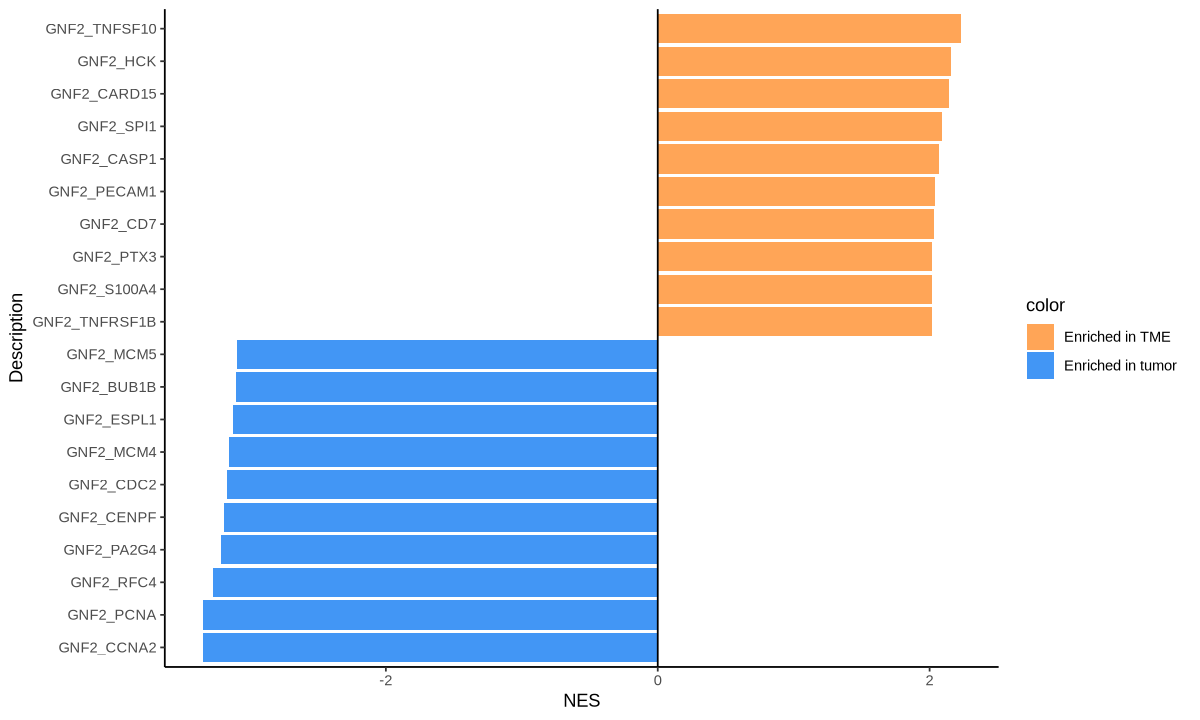

In [19]:
#set plot size
options(repr.plot.width=10, repr.plot.height=6)

#sort data and assign to "activated" or "suppressed" groups based on NES
sorted_c4<- c4@result[order(c4@result$NES, decreasing = F),]
sorted_c4$color<-ifelse(sorted_c4$NES<0, "Enriched in tumor", "Enriched in TME")

#plot results
sorted_c4 %>%
  dplyr::group_by(color) %>%
  dplyr::arrange(desc(abs(NES))) %>%
  slice_head(n = 10) %>%
  ggplot(aes(x = NES, y = reorder(Description, NES), fill = color)) +
  geom_bar(stat = "identity") +
  geom_vline(xintercept = 0) +
  labs(y = "Description") +
  theme_classic() +
  scale_fill_manual(values=c("#ffa557", "#4296f5")) +
  theme(legend.position = "right")

#save a publicaiton-quality version of the plot
ggsave("go_barplot.pdf",
        dpi = 600,
        width = 30, height = 15, unit = "cm")

Next, we can select one of these gene sets to explore more in-depth.
接下来，我们可以选择这些基因集之一来更深入地探索。

The database we are using organizes the gene pathways into sets of genes centered around known cancer-related genes. We will need to make use of the GSEA website to understand what each gene set is.
我们使用的数据库将基因通路组织成以已知癌症相关基因为中心的基因集。我们需要利用 GSEA 网站来了解每个基因集是什么。

For example, looking into one of the modules enriched in the microenvironment region, [GNF2_PECAM1](https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GNF2_PECAM1.html), we can learn more about it. First, we can take a look at the full list of genes in this gene set.
例如，查看在微环境区域中丰富的模块 GNF2_PECAM1 之一，我们可以了解更多信息。首先，我们可以看看这个基因集中的基因的完整列表。

Based on the literature, we may find promising cancer treatment targets by looking at the genes in this gene set. We can generate a GSEA plot and a cnet plot for this module to evaluate the full set of genes in our data:
根据文献，我们可能会通过查看该基因集中的基因来找到有前途的癌症治疗靶点。我们可以为这个模块生成一个 GSEA 图和一个 cnet 图，以评估我们数据中的全套基因：

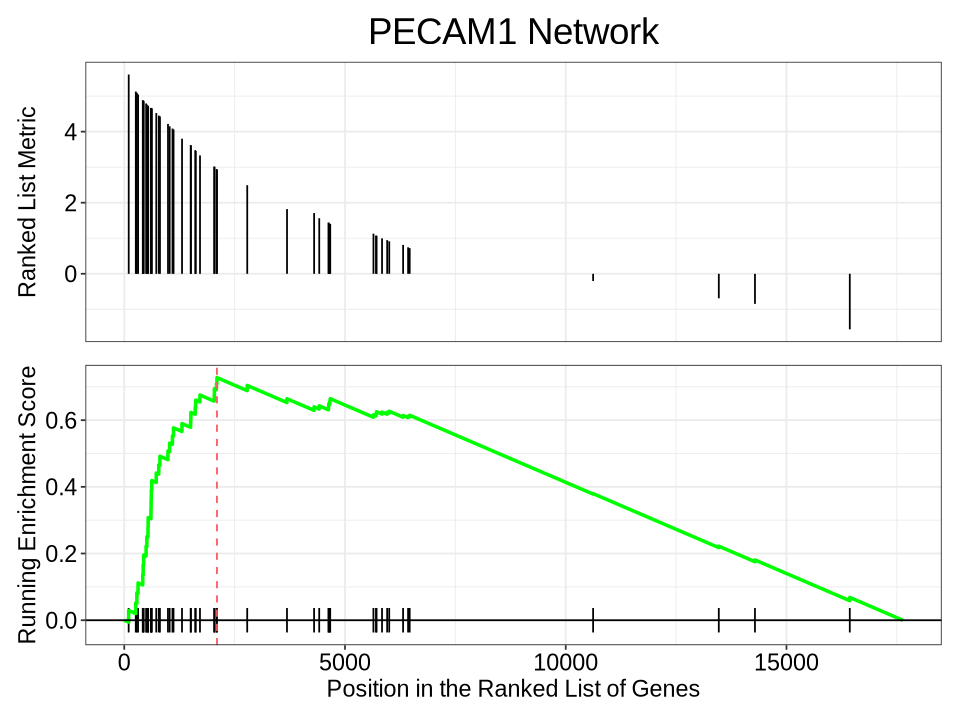

In [20]:
#re-set plot size
options(repr.plot.width=8, repr.plot.height=6)

#gsea plot
gseaplot(c4, by = "all", title = "PECAM1 Network", geneSetID = "GNF2_PECAM1")

And pull out the NES and adjusted p-value associated with this enriched set.
并提取与此丰富集关联的 NES 和调整后的 p 值。

In [21]:
c4_df["GNF2_PECAM1",]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GNF2_PECAM1,GNF2_PECAM1,GNF2_PECAM1,53,0.7274732,2.041029,2.564753e-10,3.334179e-09,1.609461e-09,2100,"tags=60%, list=12%, signal=53%",ITGB2/PECAM1/HCK/TYMP/LILRB2/FGL2/CYBB/FCER1G/CHST15/IGSF6/TYROBP/MAFB/LST1/CD93/MS4A6A/LILRA2/LILRA6/THEMIS2/AIF1/TNFAIP2/CCR1/NCF2/CLEC4A/TLR2/LILRA1/TLR8/DUSP1/RGS2/S100A4/PSAP/ADA2/TCIRG1


Of the 56 genes in this PECAM1 Gene Set, 33 were detected in our experiment. We can visualize the expression of these genes relative to the tumor region in the cnet plot below:
在这个 PECAM1 基因集中的 56 个基因中，在我们的实验中检测到 33 个。我们可以在下面的 cnet 图中可视化这些基因相对于肿瘤区域的表达：

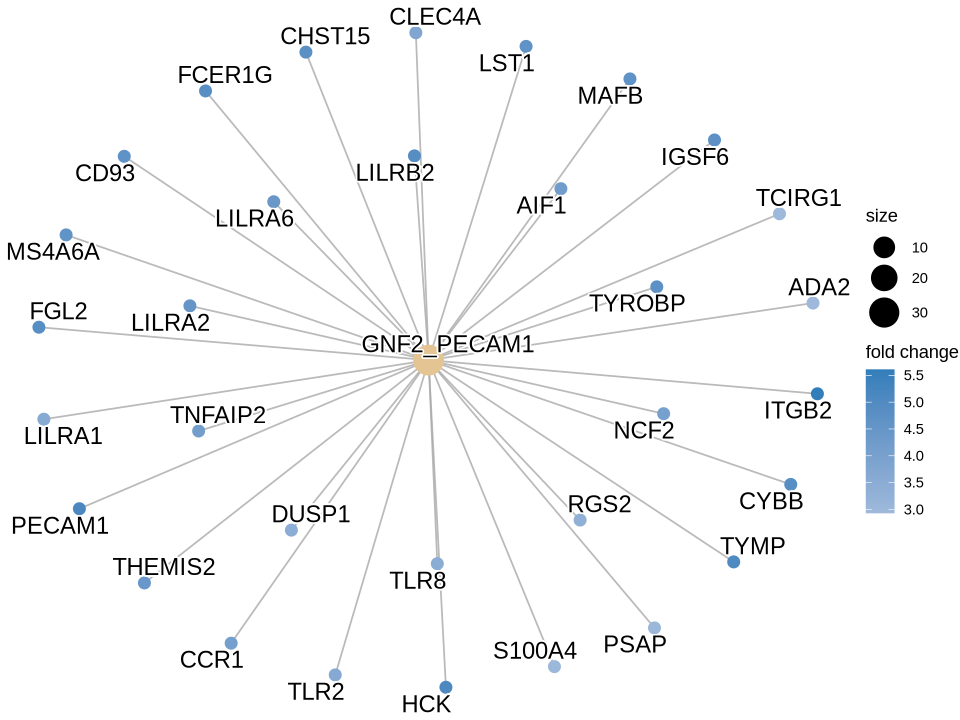

In [22]:
cnetplot(c4, categorySize="pvalue", color.params = list(foldChange=geneList), showCategory = c("GNF2_PECAM1"))

Platelet endothelial cell adhesion molecule (PECAM-1) is a cell-cell adhesion protein found on endothelial cells, platelets, macrophages and Kupffer cells, granulocytes, lymphocytes (T cells, B cells, and NK cells), megakaryocytes, and osteoclasts.Going to the literature, this gene has been studied in the cancer field. Specifically, [one study](https://doi.org/10.1073/pnas.1004654107) found that PECAM-1 in the tumor microenvironment drives advanced metastatic progression of tumor cells. [Another](https://doi.org/10.1023/A:1009092107382) found that an antibody against murine PECAM-1 inhibits tumor angiogenesis in mice.
血小板内皮细胞粘附分子 （PECAM-1） 是一种细胞间粘附蛋白，存在于内皮细胞、血小板、巨噬细胞和 Kupffer 细胞、粒细胞、淋巴细胞（T 细胞、B 细胞和 NK 细胞）、巨核细胞和破骨细胞上。去文献，这个基因已经在癌症领域进行了研究。具体来说，一项研究发现，肿瘤微环境中的 PECAM-1 会驱动肿瘤细胞的晚期转移进展。另一项研究发现，一种针对小鼠 PECAM-1 的抗体可抑制小鼠的肿瘤血管生成。

We may find promising cancer treatment targets by looking at the genes in this gene set. The PECAM1 neighborhood identified with GSEA may represent a network of genes that are involved in regulation of the the tumor microenvironment to make the area more susceptible to tumor invasion. These genes may be worth investigating in future studies and specifically targeting in future cancer treatment development. The last thing we will do is go back to Loupe Browser to visualize the expression of these genes in our tissue.
通过观察该基因集中的基因，我们可能会找到有前途的癌症治疗靶点。用 GSEA 鉴定的 PECAM1 邻域可能代表参与肿瘤微环境调节的基因网络，使该区域更容易受到肿瘤侵袭。这些基因可能值得在未来的研究中进行研究，特别是针对未来的癌症治疗开发。我们要做的最后一件事是返回 Loupe Browser 来可视化这些基因在我们组织中的表达。

In [23]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/lcr/miniconda3/envs/r-env/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] org.Hs.eg.db_3.19.1    AnnotationDbi_1.66.0   IRanges_2.38.1        
 [4] S4Vectors_0.42.1       Biobase_2.64.0         BiocGenerics_0.50.0   
 [7] forcats_1.0.0          DOSE_3.30.5            lplyr_0.1.12       